# EDA and Visualizations

## Table of Contents
- [Data Prep](#Data-Prep)
- [Most Common Words by Subreddit](#Most-Common-Words-by-Subreddit)
- [Words Which Appear More Frequently in a Given Subreddit](#Words-Which-Appear-More-Frequently-in-a-Given-Subreddit)
- [Summary](#Summary)

After our three scripts for sourcing, cleaning, and preprocessing our data have run, we are ready to perform Exploratory Data Analysis and create visualizations of our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
import json

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# Data Reading
df = pd.read_csv('../data/preprocessed_subreddit_data.csv')
df.dropna(inplace=True)

with open('../data/stop_words.json', 'r') as fp:
    stop_words = json.load(fp)

### Data Prep

In [4]:
# Create column combining title and post text, and create individual dataframes for each subreddit

df['fulltext'] = df['title'] + ' ' + df['selftext']

freefolk = df[df['subreddit']=='freefolk']
gameofthrones = df[df['subreddit']=='gameofthrones']
asoiaf = df[df['subreddit']=='asoiaf']

We will vectorize our text to perform analysis. This allows us to render the full text of a post as columns with counts of the occurrences of each word. We are using the same parameters for our vectorizer as we will pass to our modeling pipeline, which should help us see exactly what our models will see.

Keep in mind that we are ignoring generic english language stop words as well as 86 of the 100 most common words in our dataset overall which are also in the top 100 most common words for each individual subreddit.

In [7]:
df_vec = CountVectorizer(stop_words=stop_words['words'],
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

df_tab = df_vec.fit_transform(df['fulltext'])
df_pd = pd.DataFrame(df_tab.toarray(), columns=df_vec.get_feature_names())

In [8]:
ff_vec = CountVectorizer(stop_words=stop_words['words'],
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))
ff_tab = ff_vec.fit_transform(freefolk['fulltext'])
ff_pd = pd.DataFrame(ff_tab.toarray(), columns=ff_vec.get_feature_names())

In [9]:
got_vec = CountVectorizer(stop_words=stop_words['words'],
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

got_tab = got_vec.fit_transform(gameofthrones['fulltext'])
got_pd = pd.DataFrame(got_tab.toarray(), columns=got_vec.get_feature_names())

In [10]:
asoiaf_vec = CountVectorizer(stop_words=stop_words['words'],
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

asoiaf_tab = asoiaf_vec.fit_transform(asoiaf['fulltext'])
asoiaf_pd = pd.DataFrame(asoiaf_tab.toarray(), columns=asoiaf_vec.get_feature_names())

In [11]:
most_common_overall = df_pd.mean().sort_values(ascending=False)[0:100]

most_common_ff = ff_pd.mean().sort_values(ascending=False)[0:100]

most_common_got = got_pd.mean().sort_values(ascending=False)[0:100]

most_common_asoiaf = asoiaf_pd.mean().sort_values(ascending=False)[0:100]

### Most Common Words by Subreddit

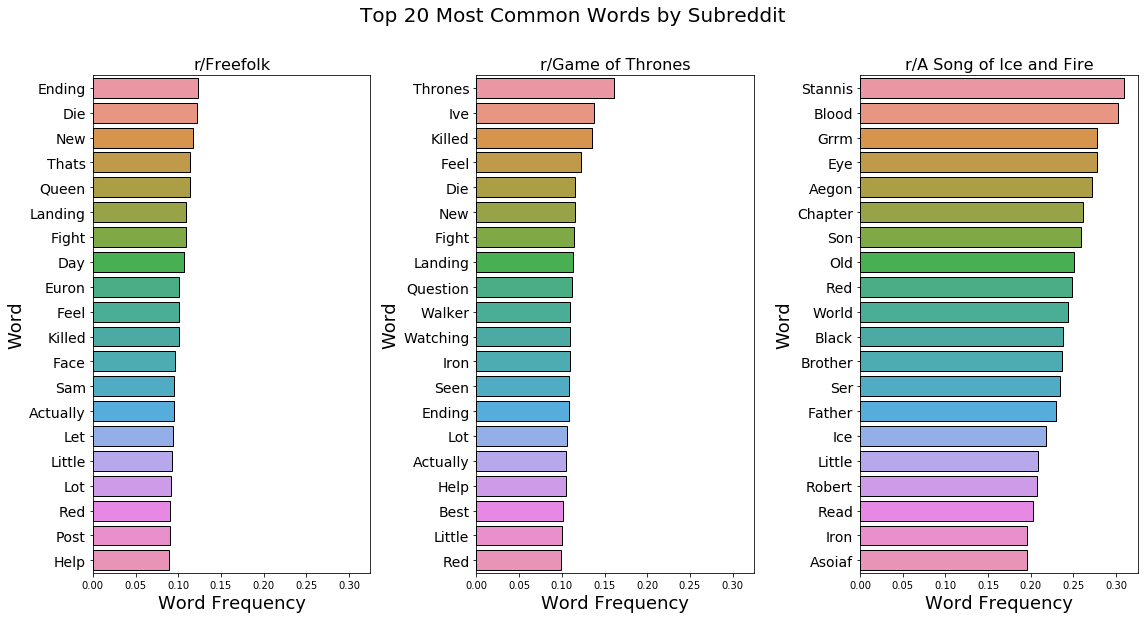

In [28]:
tables = [most_common_ff,most_common_got,most_common_asoiaf]
titles = ['r/Freefolk','r/Game of Thrones','r/A Song of Ice and Fire']

fig, ax = plt.subplots(1,3, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Top 20 Most Common Words by Subreddit', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:20],tables[i].index.str.title()[0:20], orient='h',ax=ax, ec='k', linewidth=1)
fig.tight_layout()

It is interesting that Stannis is such a comparatively hot topic in r/asoiaf. He is known to be a much more deep and fleshed-out character in the books than the television show, and there is a great degree of speculation about how certain cliffhangers around him will be resolved in the forthcoming next novel in the series.

Another character name which is high up for r/asoiaf but not the others is Aegon. This interpretation is a bit fuzzy, as there are two characters named Aegon in the series. While one is a main character in the TV show, there is a book-only character named Aegon who is theorized to be central to the denouement and resolution of the book series, and whose ancestry is somewhat called into question. Thus, many theories surrounding the novels still forthcoming and the resolution of the series include "Book Aegon's" true heritage and final fate, while show-only fans are unlikely to know or care about the character.

Perhaps the most standout word in r/asoiaf missing from the other two subs is "grrm." No, that's not a typo; it's the initials of series author George R. R. Martin. He is unsurprisingly a much more frequent fixture in book-focused discussions than TV-focused ones.

Meanwhile, the most common word in r/freefolk after our custom stopword removal is "Ending." This is unsurprising, as r/freefolk was generally much less satisfied with the ending of the television series. It's still a frequent topic in r/gameofthrones, but not to the same degree.

Some other words related to frequent complaints about the finale pop up in r/freefolk, such as "Landing" (aka "King's Landing," capital of the fictional continent of Westeros and setting of much of the last season). The character Euron also played a major role in the finale, which many on r/freefolk found to be unsatisfying, hence his strong presence in posts there.

It is also notable that about one year of this data comes from the time period between the release of Season 7 and Season 8, during which r/freefolk was the main forum for leaks, as they were banned on r/gameofthrones and confined to comments in megathreads in r/asoiaf. Thus we expect to see the difference in posts discussing the ending across all time periods.

### Words Which Appear More Frequently in a Given Subreddit

To create a visualization of the words which appear most frequently in each subreddit relative to the others, we will simply take the frequencies of each word in each subreddit and subtract the mean frequency of the other two. The highest remaining values are words which are highly specific to each subreddit.

**Caution: Profanity**

In [39]:
ff_standouts = ff_pd.mean() - got_pd.mean() - asoiaf_pd.mean()

specific_ff = ff_standouts.dropna().sort_values(ascending=False)

In [40]:
got_standouts = got_pd.mean() - ff_pd.mean() - asoiaf_pd.mean()

specific_got = got_standouts.dropna().sort_values(ascending=False)

In [41]:
asoiaf_standouts = asoiaf_pd.mean() - got_pd.mean() - ff_pd.mean()

specific_asoiaf = asoiaf_standouts.dropna().sort_values(ascending=False)

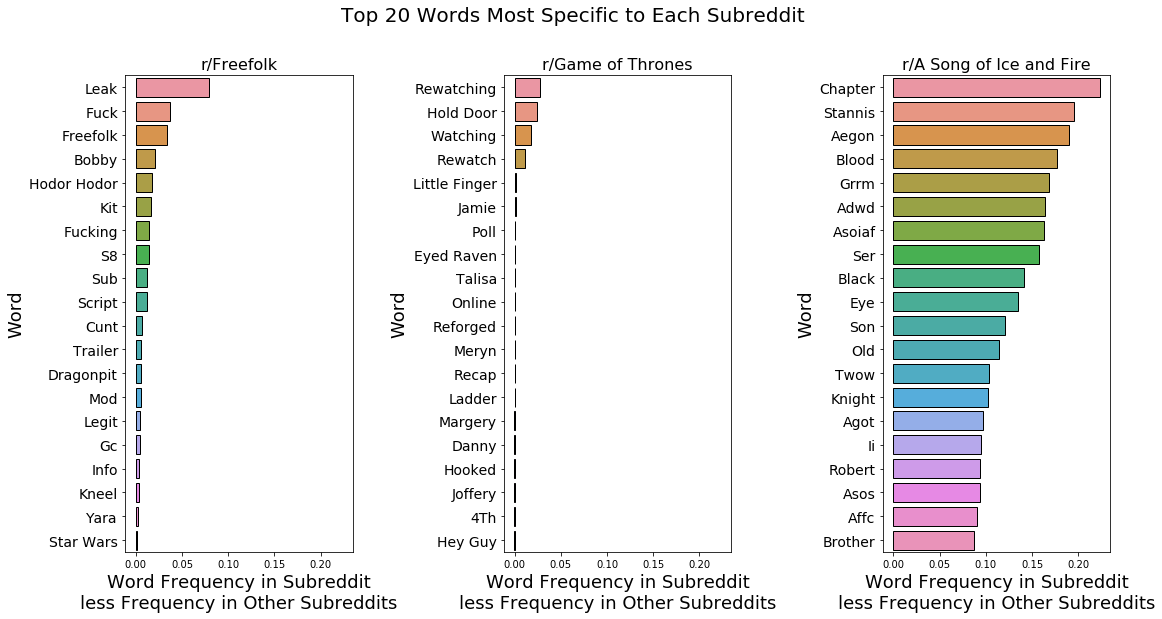

In [43]:
tables = [specific_ff,specific_got,specific_asoiaf]
titles = ['r/Freefolk','r/Game of Thrones','r/A Song of Ice and Fire']

fig, ax = plt.subplots(1,3, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Top 20 Words Most Specific to Each Subreddit', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency in Subreddit\nless Frequency in Other Subreddits', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:20],tables[i].index.str.title()[0:20], orient='h',ax=ax, ec='k', linewidth=1)
fig.tight_layout()

Here we have something slightly more informative. These are the words which are most specific to each subreddit, i.e. are much more frequent in one than the other two.

Most of the words specific to r/asoiaf are very similar to its overall most common, with the notable addition of "chapter" at the top spot. This emphasizes the book-focused orientation of the conversations there. Also in this vein, common abbreviations for the titles of the novels (I.e. TWOW = The Winds of Winter, ASOS = A Storm of Swords) appear much more frequently. One more telling feature is the frequency of the word "Ser," the spelling of "Sir" which is used in the books, and to some extent in the closed captioning on the show, but which non-book-reader fans are less likely to employ when describing a character.

r/gameofthrones stands out on two counts. First, the prevalence of positive comments related to the show, particularly "Rewatching." While not everyone on r/gameofthrones was fully satisfied with the show, it is still the go-to place of discussion for people who did like it and continue to watch it.

The second, extremely amusing feature here is the prevalence of misspelled names on r/gameofthrones. Three of the top 20 most specific words to the sub are misspellings of character names, specifically "Little Finger" (Littlefinger), "Margery" (Margaery), and "Joffery" (Joffrey). It seems casual, show-only fans have a much weaker grasp on the odd names of the setting.

Finally, to nobody's surprise, r/freefolk stands out for profanity. (To be fair to these users, a substantial portion of this is likely direct quotes from the show which are in-subreddit memes, e.g. "If any more words come pouring out your c\*\*\* mouth I'm going to have to eat every f\*\*\*\*\*\* chicken in this room.")

The number one word most specific to r/freefolk, however, is "leaks." This is extremely interpretable; the subreddit was founded in direct response to all show-related leaks being banned from r/gameofthrones, and throughout the lead-up and aftermath of the final season, alleged leaks and leak interpretations were the one type of conversation you could find there but nowhere else. 

A related term to this is "kneel." This is related to a quote by Mance Rayder, the leader of the Free Folk in A Song of Ice and Fire. It is spoken during his refusal to recognize Stannis as his King, because his people have lived beyond the reach of the central government of Westeros and, while they require shelter from certain dangers, are unwilling to submit to said government in exchange. Thus, when r/freefolk was founded to create a place for discussions of leaks in response to perceived overmoderation of r/gameofthrones, their motto was "We Do Not Kneel," and users of r/gameofthrones are typically referred to as "kneelers."

The final, possibly surprising entry we'd like to note on r/freefolk's most specific word list is "Star Wars." This is a common topic because the very unpopular showrunners of Game of Thrones signed up to direct a Star Wars trilogy sometime before the release of Season 8. Many vitriolic comments directed at them involve despair that they might ruin another beloved saga, or, later, rejoicing when Disney fired them from the job.

### Summary

By eliminating the most common words and character names among all three subreddits, we have quickly begun to tease out differences in the focus of discussion among the three subreddits, and have in the process hopefully increased our models' resistance to overfitting.

Overall, it does seem that there are significant differences between the content of text posts and titles between all three subreddits, though it may be harder to tease apart r/freefolk and r/gameofthrones than r/asoiaf. We feel confident that our models will be able to find some success in classifying posts from these three subreddits.